In [1]:
%cd /work/pi_wqd_umass_edu/pyxsim

/work/pi_wqd_umass_edu/pyxsim


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import matplotlib
import soxs
matplotlib.rc('font', size = 18)

soxs : [WARNING  ] 2024-08-06 13:58:08,418 Setting 'soxs_data_dir' to /home/dkidwell_umass_edu/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
import yt
import pyxsim
import re
import struct
import sys
import warnings
from io import open
import h5py
import astropy
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage import rotate
from astropy import wcs
import astropy.units as u
from pprint import pprint

In [25]:
ra0, dec0 = 266.42, -29 # center coords of image, from event file (updated to proper degrees)
nx = 212 # size of image, got from file (remember to update if you use a cut version)
#x=255 y=130 what is that in pixel space
dx = 0.5*u.arcsec # pixel size, you told me
#twidth = (10)

In [26]:
#loading the fits file and converting it to flux so we can plot it.
with fits.open('smass-dist.fits') as hdu2:
    data2 = hdu2[0].data
    head2 = hdu2[0].header
    flux = data2*5.5e-9*(0.5**2) # applying the conversion so we have the file in flux
    filename = 'smass-dist.fits'
    output_filename = filename.split('/')[-1]
    fits.writeto('flux_'+ output_filename, flux, header=head2, overwrite=True)

In [27]:
#cutting image to fit properly
f = "flux_smass-dist.fits"

fd = fits.getdata(f)
head = fits.getheader(f)


   #remove left side
fd1 = np.delete(fd, slice(0,150), 1)
    #remove right side (remember the right limit has already been reduced)
fd2 = np.delete(fd1,slice(312,462),1)
    #remove bottom
fd3 = np.delete(fd2,slice(0,150),0)
    #remove top(remember the top limit has already been reduced)
fd_done = np.delete(fd3,slice(312,462),0)
fits.writeto("flux_NCcut.fits",fd, header= head, overwrite=True)
print("finished")

finished


In [55]:
w = WCS(naxis=2)
w.wcs.cunit = ["deg"]*2
w.wcs.crval = [ra0, dec0] # center of image in RA, Dec
w.wcs.crpix = [1.2*(nx+1),0.6*(nx+1)] # center of image in pixel space
w.wcs.cdelt = [-dx.to_value("deg"), dx.to_value("deg")]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wheader = w.to_header()
pprint(wheader)

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                255.6 / Pixel coordinate of reference point            
CRPIX2  =                127.8 / Pixel coordinate of reference point            
CDELT1  = -0.00013888888888889 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00013888888888889 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =               266.42 / [deg] Coordinate value at reference point      
CRVAL2  =                -29.0 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =                -29

In [56]:
with fits.open("flux_NCcut.fits") as f:
    data = f[0].data.copy()
    tot_flux = data.sum()
    header = f[0].header.copy()
    header.update(wheader)
    hdu = fits.PrimaryHDU(data, header=header)
    hdu.writeto("flux_NCcut_sky.fits", overwrite=True)

In [57]:
agen = soxs.ApecGenerator(3.0, 9.0, 1000) #Changing this (to fewer bins or a smaller range (so far 3-10 has worked, will greatly reduce the photons generated 
spec = agen.get_spectrum(0.8, 1.0, 0.0, 1.0) # I normalized this to 1 at first (kT, abund, redshift, norm)
spec.rescale_flux(tot_flux, emin=4, emax=9) # now rescale by the flux from the file
spec.apply_foreground_absorption(11, model="tbabs") # n_H is The hydrogen column in units of 10**22 atoms/cm**2 we set 11


In [58]:
bkg_src = soxs.SimputSpectrum.from_spectrum("NSCcut", spec, ra0, dec0, imhdu="flux_NCcut_sky.fits")

In [59]:
#making a simput catalog of the data
sim_cat = soxs.SimputCatalog.from_source(
    "NSCcut_simput.fits", bkg_src, overwrite=True
)

soxs : [INFO     ] 2024-08-06 14:20:36,090 Appending source 'NSCcut' to NSCcut_simput.fits.


In [60]:
soxs.instrument_simulator("NSCcut_simput.fits", "NSC13cut_230ks_evt.fits", (230, "ks"),
                          "chandra_aciss_cy22", [266.42, -29], instr_bkgnd=False,
                          foreground=False, ptsrc_bkgnd=False, overwrite=True)

soxs : [INFO     ] 2024-08-06 14:20:36,666 Making observation of source in NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-08-06 14:20:36,827 Detecting events from source NSCcut.
soxs : [INFO     ] 2024-08-06 14:20:36,828 Applying energy-dependent effective area from aciss_aimpt_cy22.arf.
soxs : [INFO     ] 2024-08-06 14:20:58,389 Pixeling events.
soxs : [INFO     ] 2024-08-06 14:21:13,540 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2024-08-06 14:21:34,417 44489166 events were detected from the source.
soxs : [INFO     ] 2024-08-06 14:21:38,648 Scattering energies with RMF aciss_aimpt_cy22.rmf.


Scattering energies :   0%|          | 0/44489166 [00:00<?, ?it/s]

soxs : [INFO     ] 2024-08-06 14:21:52,737 No backgrounds will be added to this observation.
soxs : [INFO     ] 2024-08-06 14:21:52,738 Writing events to file NSC13cut_230ks_evt.fits.
soxs : [INFO     ] 2024-08-06 14:22:06,317 Observation complete.


In [61]:
soxs.write_image("NSC13cut_230ks_evt.fits", "NSC13cut_230ks_img.fits", overwrite=True)

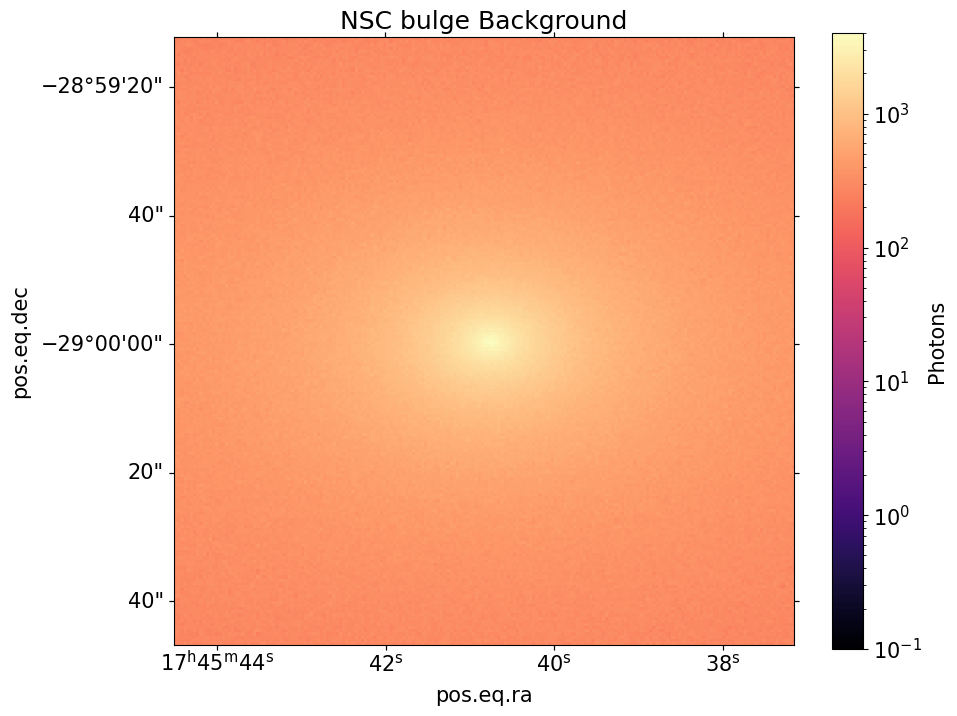

In [65]:
with fits.open("NSC13cut_230ks_img.fits") as f:
    width = 400
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("NSC bulge Background")
    fig.colorbar(p,label = 'Photons',shrink=0.80)

In [67]:
#writing spectrum and plotting it.
soxs.write_spectrum("NSC13cut_230ks_evt.fits", "stellar_bulge_evt.pha",overwrite=True) 

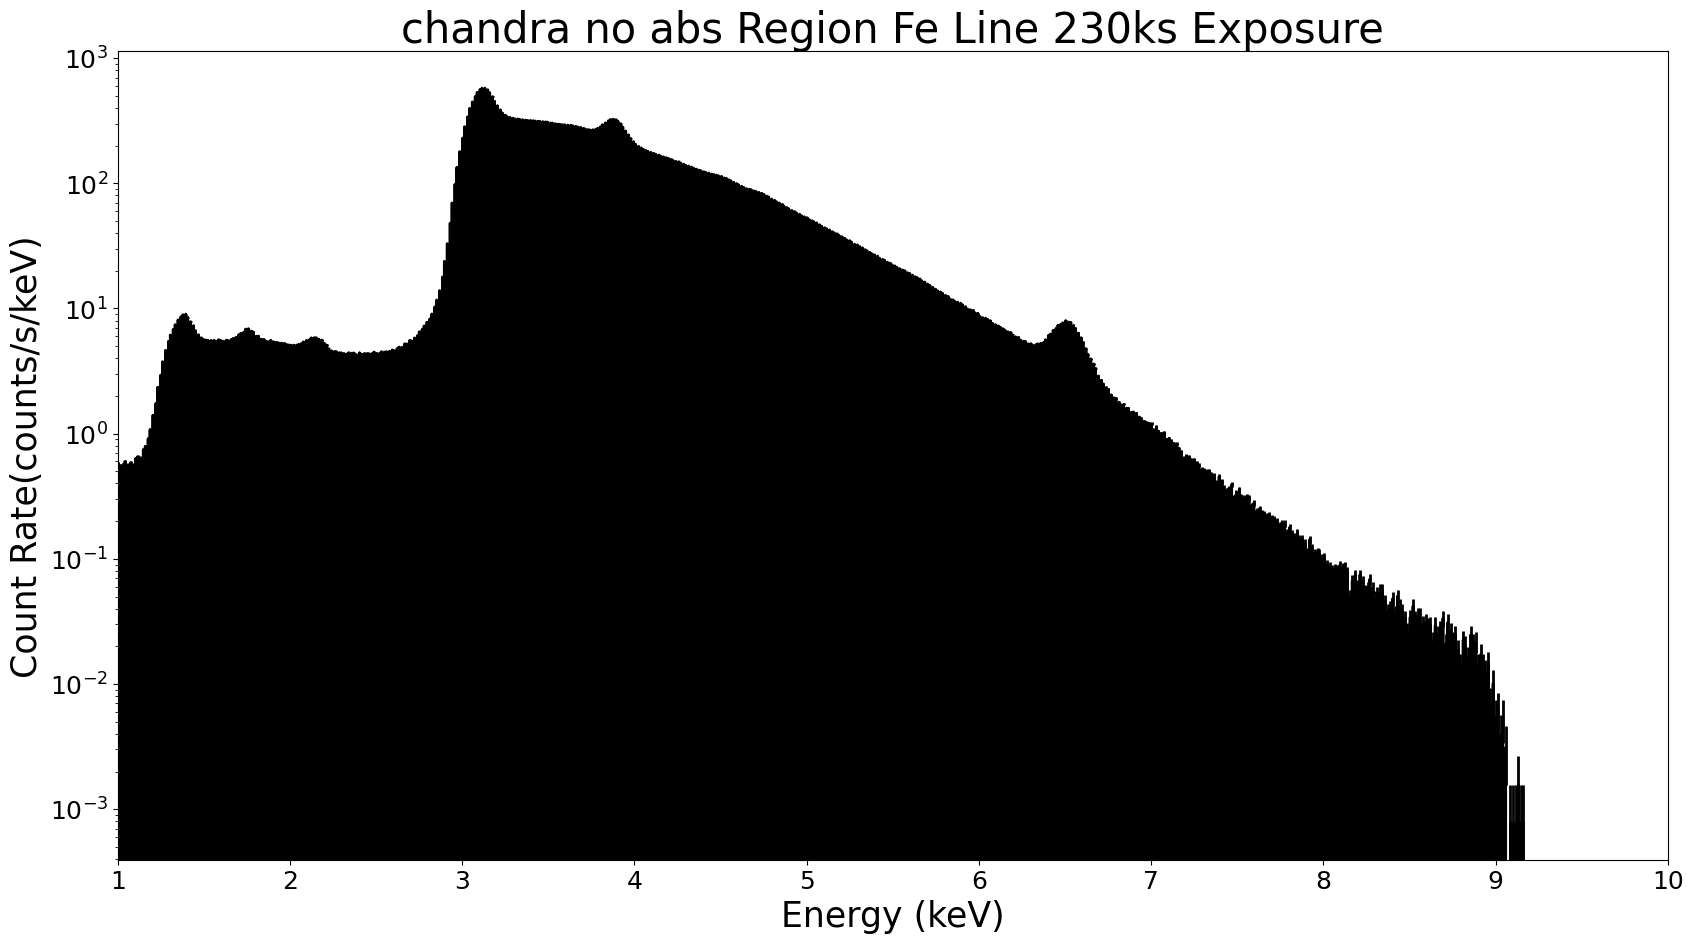

In [69]:
# when plotting with soxs remember the x-axis is not exactly Kev it is electronic signal per channel which accounts for the resolution of the instrument so we expect with chandra there be a bit signal in the 9-10 Kev range
ebin = np.linspace(1,15,2500)
fig, ax = soxs.plot_spectrum("stellar_bulge_evt.pha",xscale = 'linear',plot_energy=True, xmin=1,xmax = 10.0, noerr=False ,lw=2,ebins=ebin,label = 'Without doppler',color = 'black')
plt.rcParams['font.size'] = '25'
x = np.linspace(1,10,10)
values= np.linspace(1,10,10)
#plt.xticks(x,values,fontsize=25)
#plt.yticks(fontsize=25)
plt.xlabel('Energy (keV)', fontsize=25)
plt.ylabel('Count Rate(counts/s/keV)', fontsize=25)
plt.title('chandra no abs Region Fe Line 230ks Exposure')
#plt.ylim(0.001,0.1) #for lynx
fig.set_size_inches(20, 10.5) 

In [ ]:
soxs.write_image("totchandra_230kscut_evt.fits", "totchandra_230kscut_img.fits", overwrite=True)

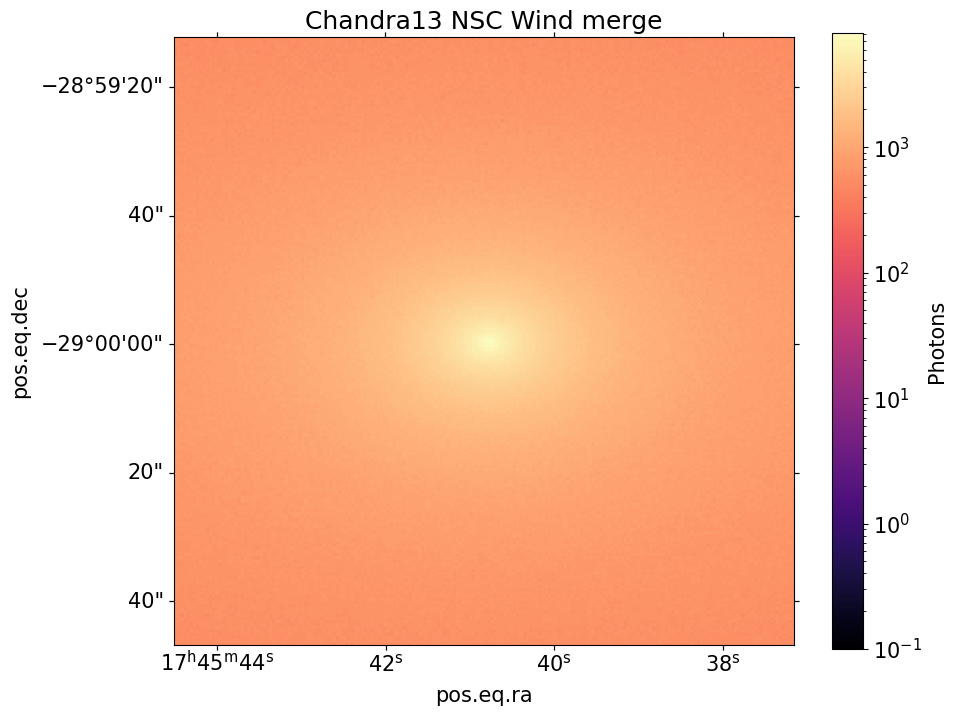

In [51]:
from astropy.io import fits
width = 400
with fits.open("totchandra_230kscut_img.fits") as f:
    hdu = f["IMAGE"] # grab the image 
    wcs = WCS(hdu.header) # grabs the coordinate system
    center = wcs.wcs.crpix # t center pixel coordinates of the image
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=wcs))
    # Create the image with a logscale
    p = ax.imshow(hdu.data, norm=LogNorm(vmin=0.1),cmap='magma')
    plt.rcParams['font.size'] = '15'
    # Sets the limits of the plot

    ax.set_xlim(center[0]-0.25*width, center[0]+0.24*width) 
    ax.set_ylim(center[1]-0.24*width, center[1]+0.24*width)
    #ax.set_title('Lynx With Doppler 230ks')
# Zeros get set to a white color
    ax.set_facecolor('black')
    #ax.tick_params(axis='x', colors='white')
    #ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    #ax.margins(x=-0.45, y=-0.25) 
    ax.set_title("Chandra13 NSC Wind merge")

    fig.colorbar(p,label = 'Photons',shrink=0.80)